# Library Imports

In [1]:
import re
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

# IGC Parsing

The first step is to extract the raw data from the IGC file and use it to calculate derived data series of relevance (e.g. climb rate, glide ratio etc.)

**NOTE:** this shows the end result and was iteratively built from the exploration section

In [42]:
def parse_igc(file_path,
              avg_window=15):
    
    # Convert IGC DDDMMmmm or DDMMmmm format to decimal degrees.
    def igc_to_decimal(igc_coordinate, direction):
        # Extract degrees, minutes, and thousandths of a minute
        if len(igc_coordinate) == 7:  # Latitude: DDMMmmm
            degrees = int(igc_coordinate[:2])
            minutes = int(igc_coordinate[2:4])
            thousandths = int(igc_coordinate[4:])
        elif len(igc_coordinate) == 8:  # Longitude: DDDMMmmm
            degrees = int(igc_coordinate[:3])
            minutes = int(igc_coordinate[3:5])
            thousandths = int(igc_coordinate[5:])
        else:
            raise ValueError("Invalid IGC coordinate format. Must be 7 or 8 characters.")

        # Convert to decimal degrees
        decimal_degrees = float(degrees + (minutes + thousandths / 1000) / 60)

        # Apply negative sign for South or West directions
        if direction in ['S', 'W']:
            decimal_degrees *= -1

        return decimal_degrees
    
    # Heading calculation between two points
    def calculate_heading(lat1, lon1, lat2, lon2):
        # Convert latitude and longitude from degrees to radians
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
        
        # Difference in longitude
        delta_lon = lon2 - lon1
        
        # Calculate initial bearing
        x = math.sin(delta_lon) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon)
        initial_bearing = math.atan2(x, y)
        
        # Convert from radians to degrees
        initial_bearing = math.degrees(initial_bearing)
        
        # Normalize to 0-360
        compass_bearing = (initial_bearing + 360) % 360
        
        return compass_bearing

    # Rate of change of heading calculation
    def heading_delta(rolling_input):
        rolling_input = list(rolling_input)

        # Adjust for 360 degree rollover, left turn
        if abs(rolling_input[0]>300) & abs(rolling_input[1]<60):
            return  (360+rolling_input[1]) - rolling_input[0]
        
        # Adjust for 360 degree rollover, right turn
        elif abs(rolling_input[0]<60) & abs(rolling_input[1]>300):
            return  (rolling_input[1]-360) - rolling_input[0]
        
        else :
            return rolling_input[1] - rolling_input[0]
    
    # Ground speed based on lat/lon
    def calculate_ground_speed(lat1, lon1, lat2, lon2, time_diff_seconds=1):
        # Radius of Earth in meters
        R = 6371000  

        # Convert latitude and longitude from degrees to radians
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

        # Calculate differences
        delta_lat = lat2 - lat1
        delta_lon = lon2 - lon1

        # Haversine formula
        a = math.sin(delta_lat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(delta_lon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance_meters = R * c  # Distance in meters

        # Calculate ground speed (distance / time)
        ground_speed = distance_meters / time_diff_seconds if time_diff_seconds > 0 else 0

        return ground_speed

    # Calculate subparameters with the rolling average window (average climb rates, glide ratio, and flight states)
    def calculate_rolling_subparams(window_data):
        # Average climb rates
        avg_gps_climb_rate = window_data['gps_climb_rate'].mean()
        avg_baro_climb_rate = window_data['baro_climb_rate'].mean()

        # Flight state calculations and conditional logic
        avg_ground_speed = window_data['ground_speed'].mean()
        avg_heading_roc = window_data['heading_roc'].mean()
        abs_avg_heading_roc = abs(avg_heading_roc)

        if avg_baro_climb_rate > 0 and abs_avg_heading_roc >= 10 :
            flight_state = 2.0  # Thermal
        elif abs_avg_heading_roc < 10 and avg_ground_speed > 3 :
            flight_state = 1.0  # Glide
        else:
            flight_state = 0.0  # Undefined
        
        # Calculate glide ratio
        glide_ratio = abs(avg_ground_speed / avg_gps_climb_rate) if avg_gps_climb_rate < 0 else 1000000

        return avg_heading_roc, avg_ground_speed, avg_gps_climb_rate, avg_baro_climb_rate, flight_state, glide_ratio

    # Thermal
    def thermal_parsing (df) :
        # id, height_gain, turn count, avg_turn_rate, turn direction, avg_climb_rate, 
        thermal_calc_df = df[df['flight_state']==2][['gps_altitude','baro_altitude', 'heading','heading_roc','gps_climb_rate','baro_climb_rate',]]

        # Initialize empty dataframe & initialize running variables
        thermal_df = pd.DataFrame(columns=['thermal_id','height_gain','turn_count','avg_turn_rate','turn_direction','avg_gps_climb_rate','avg_baro_climb_rate'])
        thermal_id = 0
        thermal_ctr = 0
        running_sum_baro_climb_rate_thermal = 0
        running_sum_gps_climb_rate_thermal = 0
        running_sum_hdg_thermal = 0
        running_sum_hdg_roc_thermal = 0
        alt_init_thermal = thermal_calc_df['gps_altitude'].iloc[0]

        # Iterate through rows in thermal_calc_df 
        for current_row, next_row in zip(thermal_calc_df.itertuples(index=True), thermal_calc_df.iloc[1:].itertuples(index=True, name='NextRow')):
            # Check if the next row is part of the same thermal, otherwise start new thermal
            if (next_row.Index - current_row.Index == 1) :
                # Check if the next row is part of the same turn direction, otherwise start new thermal
                if (current_row.heading_roc * next_row.heading_roc > 0) :
                    # Running sum updates
                    running_sum_baro_climb_rate_thermal += current_row.baro_climb_rate
                    running_sum_gps_climb_rate_thermal += current_row.gps_climb_rate
                    running_sum_hdg_thermal += current_row.heading
                    running_sum_hdg_roc_thermal += current_row.heading_roc 
                    thermal_ctr += 1

                    # Continue to the next iteration of the loop
                    continue

            # New thermal is started if neither of the above conditions is met
            # Running sum updates
            running_sum_baro_climb_rate_thermal += current_row.baro_climb_rate
            running_sum_gps_climb_rate_thermal += current_row.gps_climb_rate
            running_sum_hdg_thermal += current_row.heading
            running_sum_hdg_roc_thermal += current_row.heading_roc 
            thermal_ctr += 1

            # Value calculations
            height_gain = current_row.gps_altitude - alt_init_thermal
            turn_count = running_sum_hdg_thermal / 360
            avg_turn_rate = running_sum_hdg_roc_thermal / thermal_ctr
            turn_direction = np.sign(avg_turn_rate)
            avg_gps_climb_rate = running_sum_gps_climb_rate_thermal / thermal_ctr
            avg_baro_climb_rate = running_sum_baro_climb_rate_thermal / thermal_ctr

            # Check if thermal gain is positive and more than on turn to concatenate thermal row
            if height_gain > 0 and turn_count > 1 and abs(avg_turn_rate) > 10:
                new_thermal_group = pd.DataFrame([{
                                                'thermal_id': thermal_id,
                                                'height_gain': height_gain,
                                                'turn_count': turn_count,
                                                'avg_turn_rate': avg_turn_rate,
                                                'turn_direction': turn_direction,
                                                'avg_gps_climb_rate': avg_gps_climb_rate,
                                                'avg_baro_climb_rate': avg_baro_climb_rate
                                            }])
                thermal_df = pd.concat([thermal_df, new_thermal_group], ignore_index=True)
            
            # Counter updates and resets
            thermal_id += 1
            thermal_ctr = 0
            alt_init_thermal = next_row.gps_altitude
            running_sum_hdg_thermal = 0
            running_sum_hdg_roc_thermal = 0
            running_sum_baro_climb_rate_thermal = 0
            running_sum_gps_climb_rate_thermal = 0

        return thermal_df
    
    # Open IGC file
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Read each B-record in the IGC file and extract the corresponding information
    fixes = []
    for line in lines:
        if line.startswith("B"):
            timestamp = line[1:7]
            lat = igc_to_decimal(line[7:14], line[14:15])
            lon = igc_to_decimal(line[15:23], line[23:24])
            gps_alt = line[25:30]
            bar_alt = line[30:35]
            
            fixes.append([timestamp, lat, lon, gps_alt, bar_alt])
    
    # Create a DataFrame from the extracted raw information
    df = pd.DataFrame(fixes, columns=["time", 
                                      "latitude", 
                                      "longitude",  
                                      "gps_altitude", 
                                      "baro_altitude"
                                      ])
    df["latitude"] = df["latitude"].astype(float)
    df["longitude"] = df["longitude"].astype(float)
    df["gps_altitude"] = df["gps_altitude"].astype(float)
    df["baro_altitude"] = df["baro_altitude"].astype(float)

    # Calculate ground speed, heading, and rate of change of heading
    df['ground_speed'] = df.apply(lambda row: calculate_ground_speed(row['latitude'], row['longitude'],
                                                                     df.loc[row.name + 1, 'latitude'] if row.name + 1 < len(df) else row['latitude'],
                                                                     df.loc[row.name + 1, 'longitude'] if row.name + 1 < len(df) else row['longitude']
                                                                     ), axis=1
                            ).astype(float)
    df['heading'] = df.apply(lambda row: calculate_heading(row['latitude'], row['longitude'],
                                                           df.loc[row.name + 1, 'latitude'] if row.name + 1 < len(df) else row['latitude'],
                                                           df.loc[row.name + 1, 'longitude'] if row.name + 1 < len(df) else row['longitude']
                                                           ), axis=1
                            ).astype(float)
    df['heading_roc'] = df['heading'].rolling(window=2).apply(heading_delta,raw=False).astype(float)

    # Calculate climb rates
    df['gps_climb_rate'] = df['gps_altitude'].diff().astype(float)
    df['baro_climb_rate'] = df['baro_altitude'].diff().astype(float)
    
    # Calculate average climb rates and determine flight states per provided or standard rolling window size
    df = pd.concat([df, 
                    pd.DataFrame([calculate_rolling_subparams(df[['ground_speed','heading_roc','gps_climb_rate','baro_climb_rate']].iloc[max(0, i - avg_window + 1):i + 1])
                                if i >= avg_window - 1 else (np.nan, np.nan, np.nan)
                                for i in range(len(df))], 
                    columns=['avg_heading_roc', 'avg_ground_speed', 'avg_gps_climb_rate', 'avg_baro_climb_rate', 'flight_state','glide_ratio'])], 
                    axis=1)
    
    # Thermal parsing
    thermal_df = thermal_parsing(df)
    
    return df, thermal_df

# Exploration

In [43]:
df, thermal_df = parse_igc("../data/raw/igc/rmfalquier.2024-08-31.10-43-13.IGC")

/tmp/ipykernel_150451/1213854464.py:166: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



### Heading information

- The first plot (heading) already showed a clear distinction between gliding state and climbing state based on the stability of the heading value
- The second plot (rate of change of heading) showed that there appears to be a band between abs(0, 10) degrees per second that distinguishes gliding from other states
- The third plot (normalized histogram of rate of change of heading) shows a somewhat normally distributed distribution of the rate across the flight with a slight bias for left turns

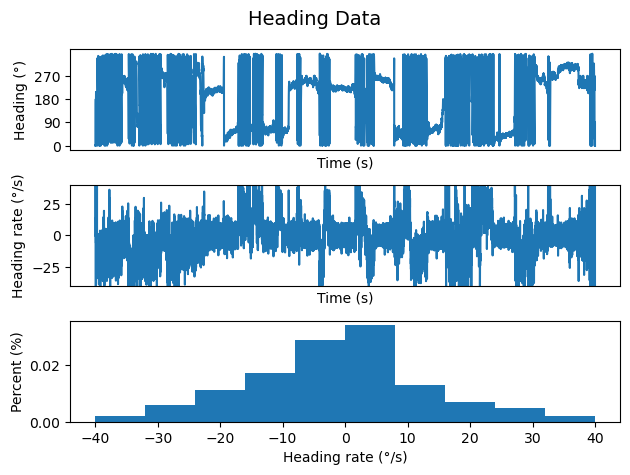

In [44]:
fig_hdg,ax_hdg = plt.subplots(3)
ax_hdg[0].set_xticks([])
ax_hdg[0].plot(df['time'],df['heading'])
ax_hdg[0].set_yticks(range(0,360,90))
ax_hdg[0].set_ylabel('Heading (°)')
ax_hdg[0].set_xlabel('Time (s)')

ax_hdg[1].set_xticks([])
ax_hdg[1].plot(df['time'],df['heading_roc'])
ax_hdg[1].set_ylim(-40,40)
ax_hdg[1].set_ylabel('Heading rate (°/s)')
ax_hdg[1].set_xlabel('Time (s)')

ax_hdg[2].hist(df['heading_roc'], range=(-40,40),density=True)
ax_hdg[2].set_ylabel('Percent (%)')
ax_hdg[2].set_xlabel('Heading rate (°/s)')

fig_hdg.suptitle('Heading Data', fontsize=14)
fig_hdg.tight_layout()

### Gliding and climbing

- The gliding histogram seems to indicate that there may be an extractable average XC glide ratio, may permit analysis that requires assumption of normal distr. to be true
- The sink rate when gliding histogram seems to indicate that there may be an extractable average sink rate, may permit analysis that requires assumption of normal distr. to be true
- The climb rate when thermalling histogram seems uninteresting at a flight level, may be useful for quality of day assessments but otherwise what you would expect

**NOTE:** The gliding state ignores values where the glide ratio is above 20 as these are for all intents and purposes irrelevant in meaningful analysis of paraglider performance

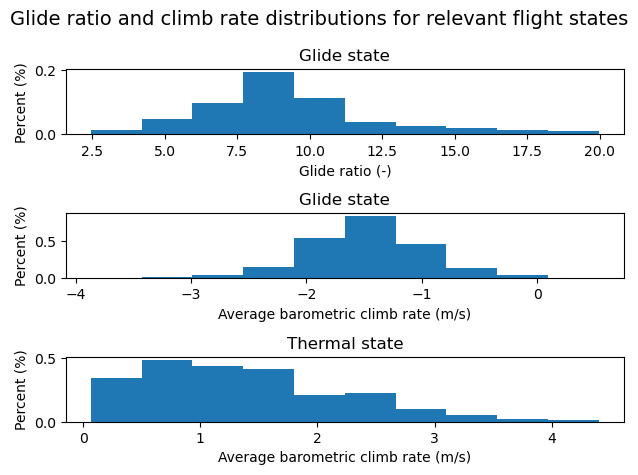

In [45]:
fig_cng,ax_cng = plt.subplots(3)
ax_cng[0].hist(df[(df['flight_state']==1) & (df['glide_ratio']<20)]['glide_ratio'], density=True)
ax_cng[0].set_ylabel('Percent (%)')
ax_cng[0].set_xlabel('Glide ratio (-)')
ax_cng[0].set_title('Glide state')

ax_cng[1].hist(df[(df['flight_state']==1) & (df['glide_ratio']<20)]['avg_baro_climb_rate'], density=True)
ax_cng[1].set_ylabel('Percent (%)')
ax_cng[1].set_xlabel('Average barometric climb rate (m/s)')
ax_cng[1].set_title('Glide state')

ax_cng[2].hist(df[df['flight_state']==2]['avg_baro_climb_rate'], density=True)
ax_cng[2].set_ylabel('Percent (%)')
ax_cng[2].set_xlabel('Average barometric climb rate (m/s)')
ax_cng[2].set_title('Thermal state')

fig_cng.suptitle('Glide ratio and climb rate distributions for relevant flight states', fontsize=14)
fig_cng.tight_layout()

### Gliding Polar Exploration
- Both plots seem to show the general shape that would be expected however, the values seem scattered on columns for respective ground speed bins. May be interesting to do a mean analysis for the corresponding sink rate and glide ratio value at each speed bin with corresponding uncertainty bands
- There appears to be a gap in data around 7 m/s which is close to approximate expected stall speed

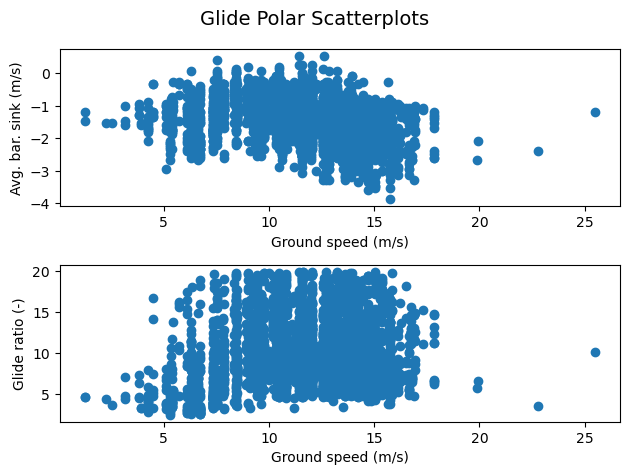

In [46]:
fig_polars,ax_polars = plt.subplots(2)

ax_polars[0].scatter(df[(df['flight_state']==1) & (df['glide_ratio']<20)]['ground_speed'],df[(df['flight_state']==1) & (df['glide_ratio']<20)]['avg_baro_climb_rate'])
ax_polars[0].set_ylabel('Avg. bar. sink (m/s)')
ax_polars[0].set_xlabel('Ground speed (m/s)')

ax_polars[1].scatter(df[(df['flight_state']==1) & (df['glide_ratio']<20)]['ground_speed'],df[(df['flight_state']==1) & (df['glide_ratio']<20)]['glide_ratio'])
ax_polars[1].set_ylabel('Glide ratio (-)')
ax_polars[1].set_xlabel('Ground speed (m/s)')

fig_polars.suptitle('Glide Polar Scatterplots', fontsize=14)
fig_polars.tight_layout()

Text(0, 0.5, 'Avg. bar. sink (m/s)')

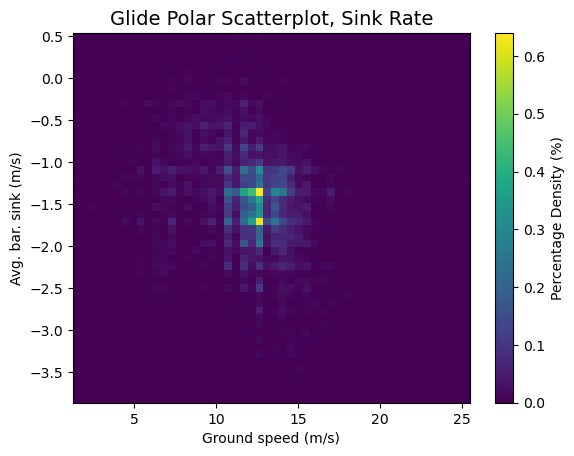

In [47]:
heatmap_climb_v_gspeed, xedges_climb_v_gspeed, yedges_climb_v_gspeed = np.histogram2d(df[(df['flight_state']==1) & (df['glide_ratio']<20)]['ground_speed'],df[(df['flight_state']==1) & (df['glide_ratio']<20)]['avg_baro_climb_rate'], bins=50, density=True)

fig_raw_polar_srate = plt.hist2d(df[(df['flight_state']==1) & (df['glide_ratio']<20)]['ground_speed'],df[(df['flight_state']==1) & (df['glide_ratio']<20)]['avg_baro_climb_rate'], bins=50, cmap='viridis', density=True)

plt.colorbar(label='Percentage Density (%)')
plt.title('Glide Polar Scatterplot, Sink Rate', fontsize=14)
plt.xlabel('Ground speed (m/s)')
plt.ylabel('Avg. bar. sink (m/s)')

Text(0, 0.5, 'Glide ratio (-)')

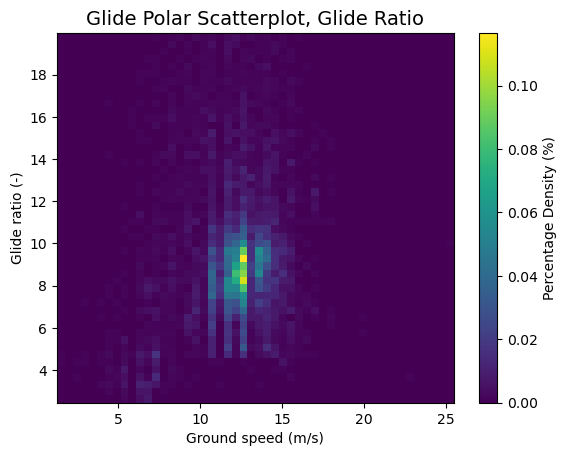

In [48]:
heatmap_climb_v_gratio, xedges_climb_v_gratio, yedges_climb_v_gratio = np.histogram2d(df[(df['flight_state']==1) & (df['glide_ratio']<20)]['ground_speed'],df[(df['flight_state']==1) & (df['glide_ratio']<20)]['glide_ratio'], bins=50, density=True)

fig_raw_polar_gratio = plt.hist2d(df[(df['flight_state']==1) & (df['glide_ratio']<20)]['ground_speed'],df[(df['flight_state']==1) & (df['glide_ratio']<20)]['glide_ratio'], bins=50, cmap='viridis', density=True)

plt.colorbar(label='Percentage Density (%)')
plt.title('Glide Polar Scatterplot, Glide Ratio', fontsize=14)
plt.xlabel('Ground speed (m/s)')
plt.ylabel('Glide ratio (-)')

### Ground speed histogram

- Not sure that there is a signal for stall speed here but could be interesting to see with more data, potentially too noisy given air speed disparity

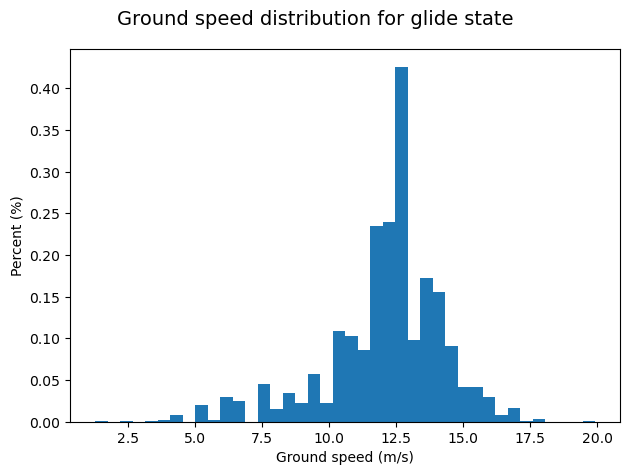

In [49]:
fig_gspd,ax_gspd = plt.subplots()

ax_gspd.hist(df[(df['flight_state']==1) & (df['glide_ratio']<20) & (df['ground_speed']<20)]['ground_speed'],bins=40,density=True)
ax_gspd.set_ylabel('Percent (%)')
ax_gspd.set_xlabel('Ground speed (m/s)')

fig_gspd.suptitle('Ground speed distribution for glide state', fontsize=14)
fig_gspd.tight_layout()

### Sanity check: plot the track and color based on flight state
- No surprises. There is likey room for improvement of the state definitions but at a first glance, seems appropriate for intended analysis

In [50]:
fig_track = go.Figure()

fig_track.add_trace(
    go.Scatter3d(
        x=df['longitude'],  # Longitude on X-axis
        y=df['latitude'],   # Latitude on Y-axis
        z=df['gps_altitude'],   # Altitude on Z-axis
        # mode='lines+markers',  # Show both line and markers
        marker=dict(size=3, color=df['flight_state'], colorscale='Inferno', showscale=True),
        # line=dict(color='blue', width=2),
        name='Flight Track'
    )
)

# Update layout for better visualization
fig_track.update_layout(
    scene=dict(
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        zaxis_title='Altitude (m)'
    ),
    title='3D IGC Track Plot',
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig_track.show()

### Climb rate vs. Rate of Turn exploration

Text(0, 0.5, 'Climb Rate (m/s)')

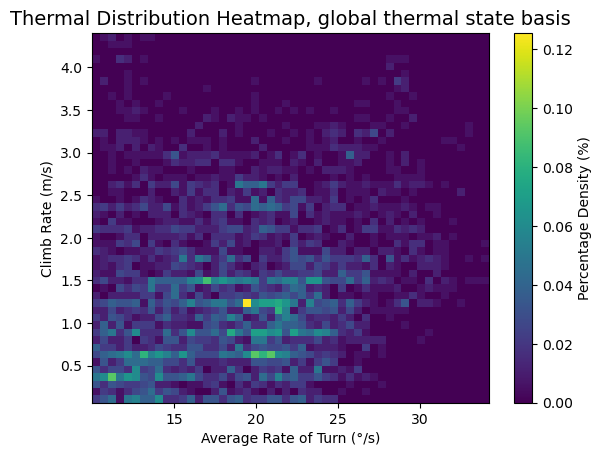

In [51]:
heatmap_climb_v_rot, xedges_climb_v_rot, yedges_climb_v_rot = np.histogram2d(df[(df['flight_state']==2)]['avg_heading_roc'].abs(),df[(df['flight_state']==2)]['avg_baro_climb_rate'], bins=50, density=True)

fig_raw_thermal = plt.hist2d(df[(df['flight_state']==2)]['avg_heading_roc'].abs(),df[(df['flight_state']==2)]['avg_baro_climb_rate'], bins=50, cmap='viridis', density=True)

plt.colorbar(label='Percentage Density (%)')
plt.title('Thermal Distribution Heatmap, global thermal state basis', fontsize=14)
plt.xlabel('Average Rate of Turn (°/s)')
plt.ylabel('Climb Rate (m/s)')

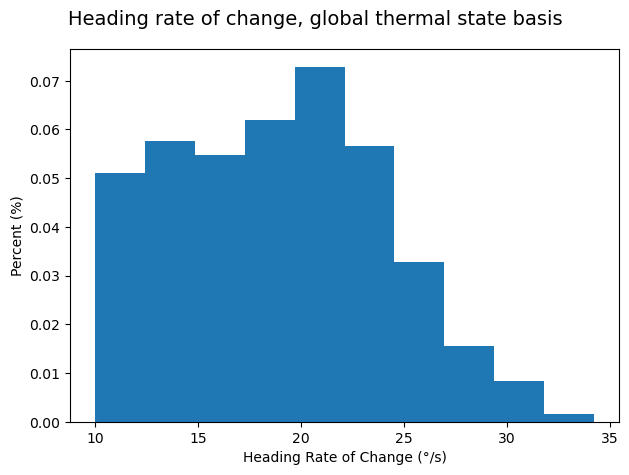

In [52]:
fig_roc_glob_th,ax_roc_glob_th = plt.subplots()

ax_roc_glob_th.hist(df[(df['flight_state']==2)]['avg_heading_roc'].abs(),density=True)
ax_roc_glob_th.set_ylabel('Percent (%)')
ax_roc_glob_th.set_xlabel('Heading Rate of Change (°/s)')

fig_roc_glob_th.suptitle('Heading rate of change, global thermal state basis', fontsize=14)
fig_roc_glob_th.tight_layout()

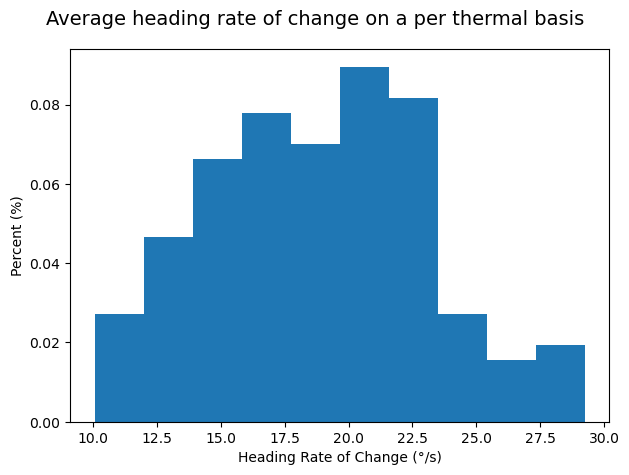

In [53]:
fig_roc_th,ax_roc_th = plt.subplots()

ax_roc_th.hist(thermal_df['avg_turn_rate'].abs(),density=True)
ax_roc_th.set_ylabel('Percent (%)')
ax_roc_th.set_xlabel('Heading Rate of Change (°/s)')

fig_roc_th.suptitle('Average heading rate of change on a per thermal basis', fontsize=14)
fig_roc_th.tight_layout()

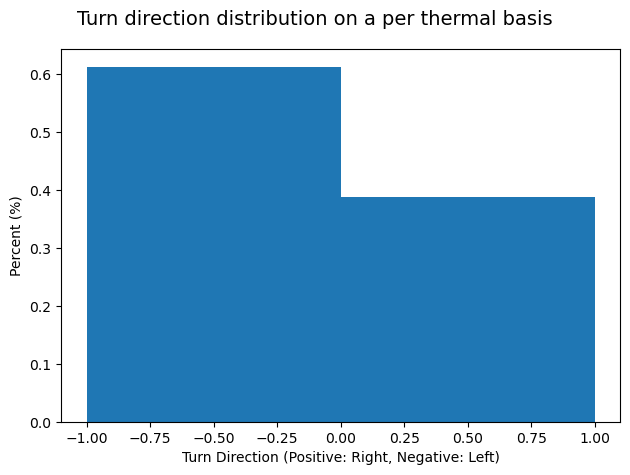

In [54]:
fig_roc_dir_th,ax_roc_dir_th = plt.subplots()

ax_roc_dir_th.hist(thermal_df['turn_direction'],bins=2,density=True)
ax_roc_dir_th.set_ylabel('Percent (%)')
ax_roc_dir_th.set_xlabel('Turn Direction (Positive: Right, Negative: Left)')

fig_roc_dir_th.suptitle('Turn direction distribution on a per thermal basis', fontsize=14)
fig_roc_dir_th.tight_layout()

Text(0, 0.5, 'Climb Rate (m/s)')

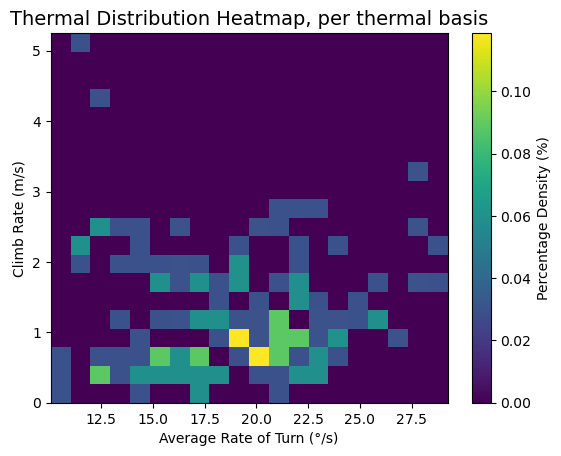

In [55]:
heatmap_climb_v_rot, xedges_climb_v_rot, yedges_climb_v_rot = np.histogram2d(thermal_df['avg_turn_rate'].abs(),thermal_df['avg_baro_climb_rate'], bins=20, density=True)

fig_procesed_thermal = plt.hist2d(thermal_df['avg_turn_rate'].abs(),thermal_df['avg_gps_climb_rate'], bins=20, cmap='viridis', density=True)

plt.colorbar(label='Percentage Density (%)')
plt.title('Thermal Distribution Heatmap, per thermal basis', fontsize=14)
plt.xlabel('Average Rate of Turn (°/s)')
plt.ylabel('Climb Rate (m/s)')

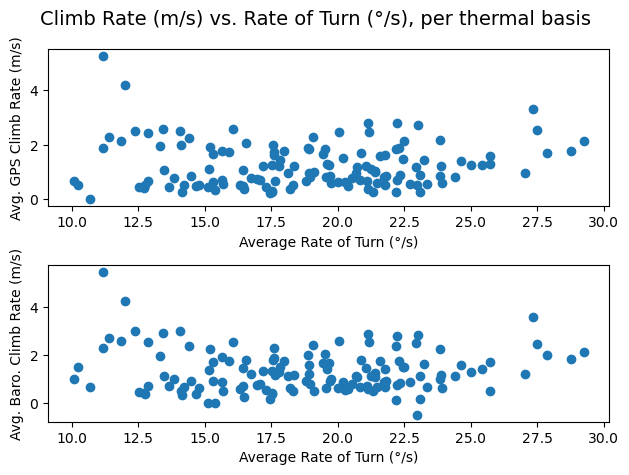

In [56]:
# Scatter Plot of Thermal Data - Turn Rate vs. GPS Climb Rate
fig_climb_scatter,ax_climb_scatter = plt.subplots(2)

ax_climb_scatter[0].scatter(thermal_df['avg_turn_rate'].abs(),thermal_df['avg_gps_climb_rate'])
ax_climb_scatter[0].set_ylabel('Avg. GPS Climb Rate (m/s)')
ax_climb_scatter[0].set_xlabel('Average Rate of Turn (°/s)')

ax_climb_scatter[1].scatter(thermal_df['avg_turn_rate'].abs(),thermal_df['avg_baro_climb_rate'])
ax_climb_scatter[1].set_ylabel('Avg. Baro. Climb Rate (m/s)')
ax_climb_scatter[1].set_xlabel('Average Rate of Turn (°/s)')

fig_climb_scatter.suptitle('Climb Rate (m/s) vs. Rate of Turn (°/s), per thermal basis', fontsize=14)
fig_climb_scatter.tight_layout()

### Mean statistical analysis for ground speed bins

In [ ]:
# TODO: extraction of the mean for each ground speed bin for glide ratio and sink rate to draw a statistical polar based on statistical mean sampling theorem
# TODO: define a confidence interval for glide ratio value

### Feature Engineering

In [ ]:
# TODO: define features from metrics writeups (climb to distance ratio etc.)


### General Statistical Exploration


In [ ]:
# TODO: use .describe method

# Writeup

Thoughts:
- Importance of sourcing actual XC flights to avoid introducing bias into the data, worth sourcing what that means (e.g. 50km at minimum 15km/h)

In [ ]:
# TODO: analyze all my tracks and generate a report with thermalling, gliding, and climbing statistics 
# BONUS: Include tracks from Chrigel or other high performing pilot

# Outputs

In [ ]:
# TODO: dataframe for thermal and glide flight state data
# TODO: dataframe for thermal counter
# TODO: dataframe for enhanced xcontest_dashboard
# TODO: dashboard for chosen metrics with upload of igc file